# SIGMA \begin{equation*} \frac{\partial V}{\partial t} = \Psi + \Omega \end{equation*}
## **SOSE**

### rolling and slicing wg for `ds_tns` and `ds_vel`, and saving to cloud

### Begin nb

In [1]:
from dask_gateway import GatewayCluster

cluster = GatewayCluster()
cluster.scale(30)
#cluster.adapt(minimum=2, maximum=10)  # or cluster.scale(n) to a fixed size.
client = cluster.get_client()

In [10]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.a2920e886d134bee9658dc7324eb603d Dashboard: /services/dask-gateway/clusters/prod.a2920e886d134bee9658dc7324eb603d/status,Cluster Workers: 4 Cores: 8 Memory: 34.36 GB


In [84]:
from dask_gateway import Gateway
g = Gateway()
g.list_clusters()[0].name

'prod.6e7540a9186c4da5b4d1e1ee57806ff7'

In [170]:
client.close()
cluster.close()

In [3]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
import gsw
from fastjmd95 import jmd95numba
from fastjmd95 import rho, drhods, drhodt

In [4]:
xr.set_options(display_style='text')

In [49]:
#coords = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/coords_wg.zarr')) #didn't upload wg region
coords = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/coords_wg.zarr'))
ds_tns = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_tns_wg.zarr'))
ds_vel = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_vel_wg.zarr'))
ds_sig_theta = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_sig_theta_wg.zarr'))
ds_sig_salt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_sig_salt_wg.zarr'))
ds_drhodts = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/drhodts_wg.zarr'))
empmr = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_SIempmr_wg.zarr'))
#ds_tmp_slt_wg = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/ds_tmp_slt_wg.zarr')) #from sigma-budget-zspace-sose.ipynb

In [58]:
ds = xr.merge([ds_sig_theta, ds_sig_salt, ds_drhodts, ds_vel])#, empmr])
ds

<xarray.Dataset>
Dimensions:                   (XC: 570, XG: 571, YC: 95, YG: 96, Z: 42, Zl: 42, time: 438)
Coordinates:
  * XC                        (XC) float32 295.1 295.2 295.4 ... 29.75 29.92
  * YC                        (YC) float32 -77.87 -77.71 ... -62.37 -62.21
  * Z                         (Z) float32 -5.0 -15.5 ... -5.325e+03 -5.575e+03
  * time                      (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * XG                        (XG) float32 295.0 295.2 295.3 ... 29.83 30.0
  * YG                        (YG) float32 -77.96 -77.79 ... -62.29 -62.12
  * Zl                        (Zl) float32 0.0 -10.0 ... -5.2e+03 -5.45e+03
Data variables:
    conv_horiz_adv_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_horiz_diff_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_adv_flux_TH     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_diff_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    lin_fs_correction_TH      (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    surface_flux_conv_TH      (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    sw_flux_conv_TH           (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    total_tendency_TH_truth   (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    lin_fs_correction_SLT     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    surface_flux_conv_SLT     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    total_tendency_SLT_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    drhods_wg                 (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    drhodt_wg                 (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    UVEL                      (time, Z, YC, XG) float32 dask.array<chunksize=(1, 42, 95, 571), meta=np.ndarray>
    VVEL                      (time, Z, YG, XC) float32 dask.array<chunksize=(1, 42, 96, 570), meta=np.ndarray>
    WSLTMASS                  (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    WTHMASS                   (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    WVEL                      (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>

In [7]:
pref = 2000

In [8]:
mask = ds.surface_flux_conv_SLT.where(ds.surface_flux_conv_SLT!=0)

In [9]:
mask

<xarray.DataArray 'surface_flux_conv_SLT' (time: 438, Z: 42, YC: 95, XC: 570)>
dask.array<where, shape=(438, 42, 95, 570), dtype=float32, chunksize=(1, 42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

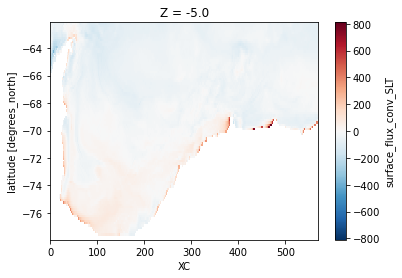

In [11]:
mask.mean(dim='time')[0].drop('XC').plot()

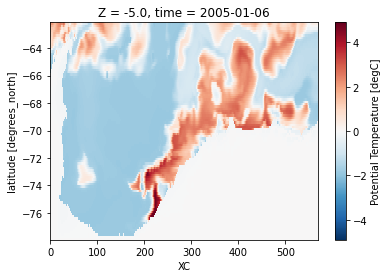

In [12]:
ds_tns.THETA[0,0].where(mask[0,0]).drop('XC').plot()

### Checking if `rhs` and `lhs` seem to match

In [13]:
ds_sig_salt.data_vars

Data variables:
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    lin_fs_correction_SLT     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    surface_flux_conv_SLT     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>
    total_tendency_SLT_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 95, 570), meta=np.ndarray>

In [14]:
rhs_vars_theta = [dvar for dvar in ds_sig_theta.data_vars
                  if dvar != 'total_tendency_TH_truth']
rhs_vars_salt = [dvar for dvar in ds_sig_salt.data_vars
                  if dvar != 'total_tendency_SLT_truth']

In [15]:
theta_sum = sum([ds_sig_theta[dvar] for dvar in rhs_vars_theta])
salt_sum = sum([ds_sig_salt[dvar] for dvar in rhs_vars_salt])
total_tendency_check = theta_sum + salt_sum
total_tendency_check

<xarray.DataArray (time: 438, Z: 42, YC: 95, XC: 570)>
dask.array<add, shape=(438, 42, 95, 570), dtype=float32, chunksize=(1, 42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

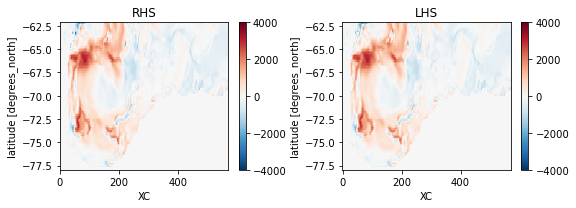

In [16]:
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8, 3))
total_tendency_check[1, 0].drop('XC').plot(ax=ax0, robust=True, vmax=4e3)
ax0.set_title('RHS')

(ds.total_tendency_TH_truth + ds.total_tendency_SLT_truth)[1, 0].drop('XC').plot(ax=ax1, robust=True, vmax=4e3)
ax1.set_title('LHS')
plt.tight_layout();

# <font color='Green'>\begin{equation*} \sigma_2\ term \end{equation*} </font>

In [17]:
import dask.array as dsa

In [17]:
sigma2 = xr.apply_ufunc(jmd95numba.rho, ds_tns.SALT, ds_tns.THETA, pref,
                            output_dtypes=[ds_tns.SALT.dtype],
                            dask='parallelized').reset_coords(drop=True)#.load()

In [18]:
sigma2

<xarray.DataArray (time: 438, Z: 42, YC: 95, XC: 570)>
dask.array<transpose, shape=(438, 42, 95, 570), dtype=float64, chunksize=(1, 42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

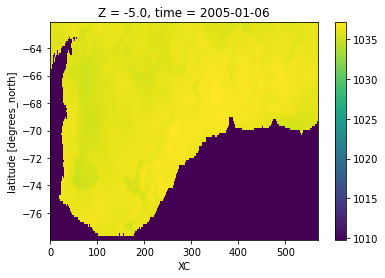

In [16]:
sigma2[0,0].drop('XC').plot()

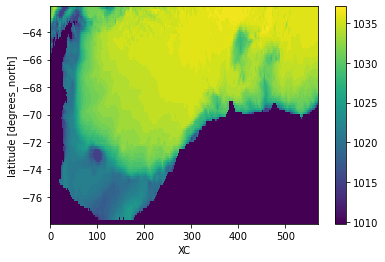

In [18]:
sigma2.mean(dim=['time', 'Z']).drop('XC').plot()

### Volume-weighted $\frac{\partial{\sigma_2}}{\partial t} =$ _tottend_truth_

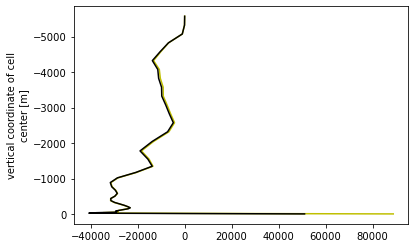

In [19]:
delta_sigma = sigma2.isel(time=-1) - sigma2.isel(time=0)
total_time = (sigma2.time[-1] - sigma2.time[0]).astype('f8')*1e-9

vol = (coords.drF * coords.rA * coords.hFacC)
((delta_sigma * vol).sum(dim=['YC', 'XC'])/ total_time).plot(y='Z', yincrease=False, color='y')
(ds.total_tendency_SLT_truth + ds.total_tendency_TH_truth).sum(dim=['YC', 'XC']).mean(dim='time').plot(y='Z', yincrease=False, color='k')

# <font color='Green'>\begin{equation*} \frac{\partial V}{\partial t} == \Omega_{tottend-\sigma-truth} + R1 \end{equation*} </font>

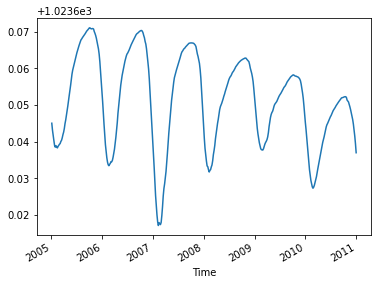

In [22]:
#looks strange but it's similar to ECCO considering the shorter time period
#density avged over volume gets denser in middle of the year (AA winter) and lighter around spring/summer
sigma2.mean(dim=['XC', 'YC', 'Z']).plot()

In [28]:
sigma2.min().values

array(1009.78870743)

In [29]:
sigma2.max().values

array(1037.55056821)

In [30]:
sigma2.where(mask).min().values

array(1009.78870743)

In [20]:
# define bins
delta_sigma = 0.01
sigma_bins = np.arange(1035.55, 1037.55, delta_sigma)

In [21]:
sigma_bins.size

200

In [22]:
ds = ds.chunk({'XC':-1, 'YC':-1, 'Z':-1, 'XG':-1, 'YG':-1, 'Zl':-1, 'time':1})
coords = coords.chunk({'XC':-1, 'YC':-1, 'Z':-1, 'XG':-1, 'YG':-1, 'Zl':-1, 'time':1})

In [23]:
sigma_dist = histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                       weights=vol, dim=['XC', 'YC', 'Z']).load()

In [24]:
sigma_dist

<xarray.DataArray 'histogram_sigma2' (time: 438, sigma2_bin: 199)>
array([[1.13423144e+11, 1.31609551e+11, 1.57247256e+11, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.32335867e+11, 1.35934326e+11, 1.52830657e+11, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.55675558e+10, 7.18447876e+10, 1.00385727e+11, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.46686310e+09, 4.68402163e+09, 1.48489843e+09, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.07137587e+09, 1.60360922e+09, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.79996928e+09, 4.59207616e+09, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.036e+03 1.036e+03 ... 1.038e+03 1.038e+03

(1036.9, 1037.3)

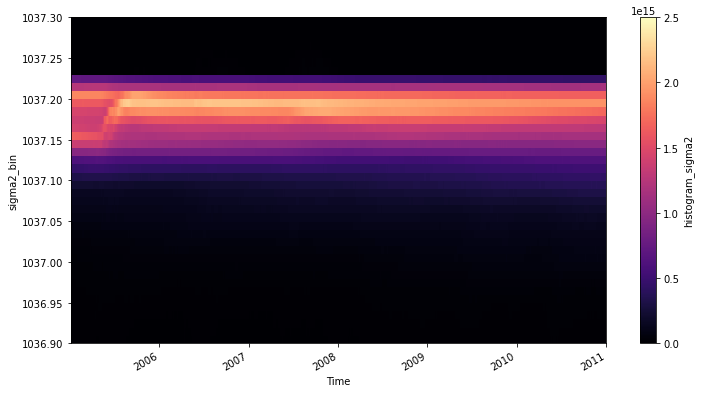

In [22]:
#most volumous water has densities up to 1037.20kg/m^3
#how to check the single-value density for most volumous?
sigma_dist.plot(x='time', figsize=(12, 6), vmax=2.5e15, cmap='magma')
plt.ylim(1036.9, 1037.3)

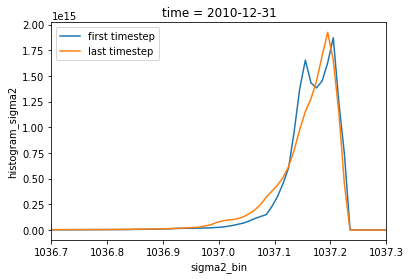

In [29]:
#waters with density up to 1037.13 got denser?
sigma_dist[0].plot(label='first timestep')
sigma_dist[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1036.7, 1037.3);

(1037.5, 1036.4)

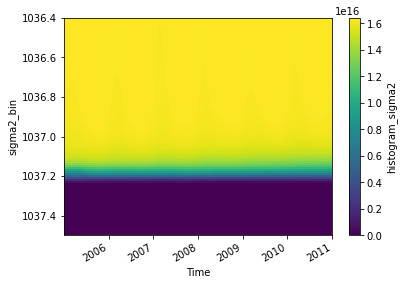

In [25]:
# cumulative volume
V = sigma_dist.isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
V.transpose().plot()
plt.ylim(1037.5, 1036.4)

In [24]:
V

<xarray.DataArray 'histogram_sigma2' (time: 438, sigma2_bin: 199)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.64139676e+16, 1.64140992e+16, 1.64142127e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.64159155e+16, 1.64160514e+16, 1.64161838e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.64163349e+16, 1.64164068e+16, 1.64164724e+16],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.64173384e+16, 1.64173431e+16, 1.64173446e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.64173369e+16, 1.64173385e+16, 1.64173416e+16],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.64173051e+16, 1.64173097e+16, 1.64173145e+16]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.038e+03 1.038e+03 ... 1.036e+03 1.036e+03

(1037.5, 1036.5)

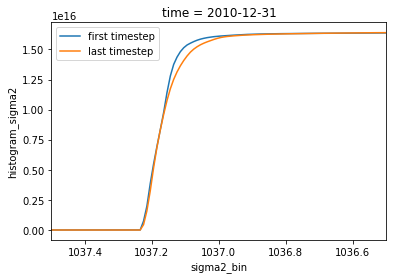

In [32]:
#waters with densities up to 1037.0 became lost volume and moved into denser sigma bins?
V[0].plot(label='first timestep')
V[-1].plot(label='last timestep')
plt.legend()
plt.xlim(1037.5, 1036.5)

In [26]:
delta_V = V.diff(dim='time')

In [27]:
delta_V

<xarray.DataArray 'histogram_sigma2' (time: 437, sigma2_bin: 199)>
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.94787812e+12,  1.95220289e+12,  1.97111561e+12],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.19444862e+11,  3.55355323e+11,  2.88587012e+11],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -5.05210419e+09,  2.12652559e+10,  3.74589320e+10],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -9.12162227e+09, -5.92249907e+09, -7.55408371e+09],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.48489843e+09, -4.56531085e+09, -2.96079808e+09],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.18640164e+10, -2.88755494e+10, -2.71469560e+10]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.038e+03 1.038e+03 ... 1.036e+03 1.036e+03

In [28]:
dt = ds.time.diff(dim='time').astype(np.float64) / 1e9

In [28]:
dt.time

<xarray.DataArray 'time' (time: 437)>
array(['2005-01-11T00:00:00.000000000', '2005-01-16T00:00:00.000000000',
       '2005-01-21T00:00:00.000000000', ..., '2010-12-21T00:00:00.000000000',
       '2010-12-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

## $\frac{\partial \mathcal{V}}{\partial t}$

In [36]:
delta_V.time

<xarray.DataArray 'time' (time: 437)>
array(['2005-01-11T00:00:00.000000000', '2005-01-16T00:00:00.000000000',
       '2005-01-21T00:00:00.000000000', ..., '2010-12-21T00:00:00.000000000',
       '2010-12-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

In [37]:
dt.time.dtype

dtype('<M8[ns]')

In [38]:
dt.time

<xarray.DataArray 'time' (time: 437)>
array(['2005-01-11T00:00:00.000000000', '2005-01-16T00:00:00.000000000',
       '2005-01-21T00:00:00.000000000', ..., '2010-12-21T00:00:00.000000000',
       '2010-12-26T00:00:00.000000000', '2010-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

In [29]:
dVdt = delta_V / dt

In [30]:
dVdt

<xarray.DataArray (time: 437, sigma2_bin: 199)>
array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.50897712e+06,  4.51898817e+06,  4.56276762e+06],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.70937180e+05,  8.22581767e+05,  6.68025491e+05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.16946856e+04,  4.92251293e+04,  8.67104907e+04],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.11148664e+04, -1.37094886e+04, -1.74863049e+04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.43726489e+03, -1.05678492e+04, -6.85369926e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -7.37592972e+04, -6.68415496e+04, -6.28401760e+04]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-11 2005-01-16 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.038e+03 1.038e+03 ... 1.036e+03 1.036e+03

(1035.5, 1037.3)

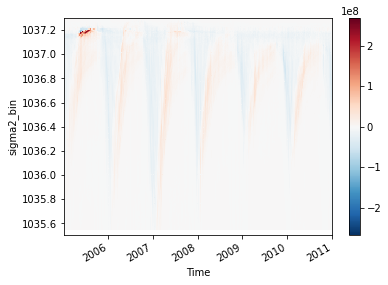

In [27]:
dVdt.plot(x='time')
plt.ylim(1035.5, 1037.3)

## $\Omega_{total}$

In [28]:
omega_total_th = - histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                          weights=ds.total_tendency_TH_truth.fillna(0.),
                          dim=['XC', 'YC', 'Z']) / (- delta_sigma)
omega_total_th.load()

omega_total_slt = - histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                          weights=ds.total_tendency_SLT_truth.fillna(0.),
                          dim=['XC', 'YC', 'Z']) / (-delta_sigma)
omega_total_slt.load()

omega_total = omega_total_th + omega_total_slt
omega_total.load()

<xarray.DataArray 'histogram_sigma2' (time: 438, sigma2_bin: 199)>
array([[-7172956.10454818, -7655417.42540483, -8085171.1515464 , ...,
               0.        ,        0.        ,        0.        ],
       [ 2504602.97945385,  1667390.14222579,  3906577.14988093, ...,
               0.        ,        0.        ,        0.        ],
       [  296299.10556494,   403174.45544963,   581782.68925796, ...,
               0.        ,        0.        ,        0.        ],
       ...,
       [  -39980.49972141,  -107475.9904712 ,   -34312.24048652, ...,
               0.        ,        0.        ,        0.        ],
       [   69205.99491557,    81527.30795351,        0.        , ...,
               0.        ,        0.        ,        0.        ],
       [  131151.84057438,  -193441.38385013,        0.        , ...,
               0.        ,        0.        ,        0.        ]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.036e+03 1.036e+03 ... 1.038e+03 1.038e+03

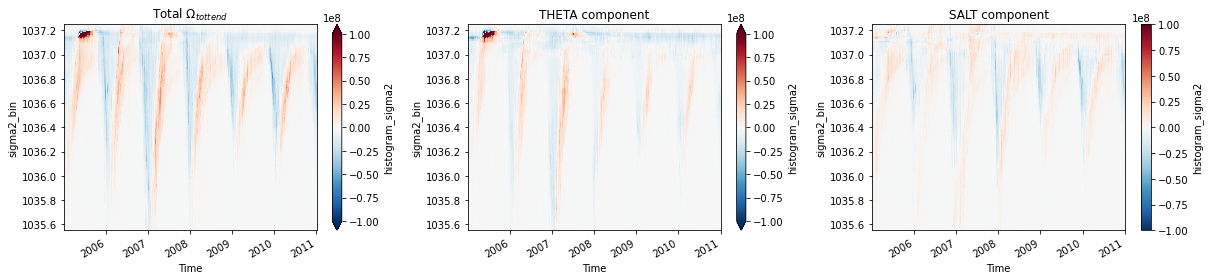

In [29]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

omega_total.plot(x='time', vmax=1e8, ax=ax0)
ax0.set_ylim(ymax=1037.25)
ax0.set_title(r'Total $\Omega_{tottend}$')

omega_total_th.plot(x='time', vmax=1e8, ax=ax1)
ax1.set_ylim(ymax=1037.25)
ax1.set_title('THETA component')

omega_total_slt.plot(x='time', vmax=1e8, ax=ax2)
ax2.set_ylim(ymax=1037.25)
ax2.set_title('SALT component')

plt.tight_layout();

## <font color='Green'>\begin{equation*} R1 = \frac{\partial \mathcal{V}}{\partial t} - \Omega_{total} \end{equation*} (Discretization of salt layers) </font>

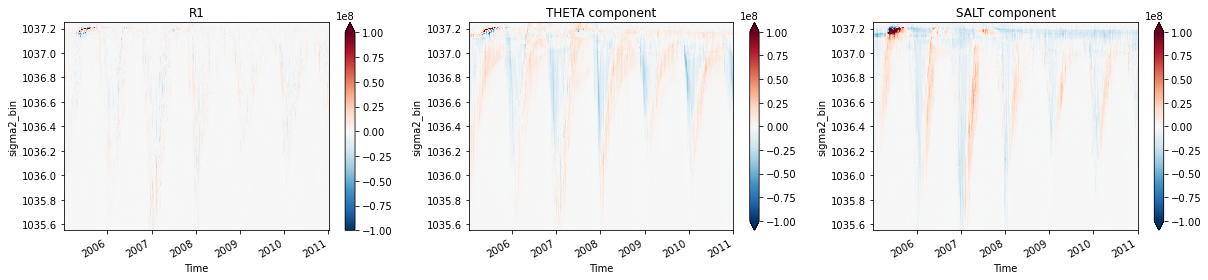

In [30]:
R1 = dVdt - omega_total
R1_th = dVdt - omega_total_th
R1_slt = dVdt - omega_total_slt

fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

R1.plot(x='time', vmax=1e8, ax=ax0)
ax0.set_ylim(ymax=1037.25)
ax0.set_title('R1')

R1_th.plot(x='time', vmax=1e8, ax=ax1)
ax1.set_ylim(ymax=1037.25)
ax1.set_title('THETA component')

R1_slt.plot(x='time', vmax=1e8, ax=ax2)
ax2.set_ylim(ymax=1037.25)
ax2.set_title('SALT component')

plt.tight_layout();

In [31]:
plot_terms = np.array([[dVdt, omega_total, R1], [dVdt, omega_total_th, R1_th], [dVdt, omega_total_slt, R1_slt]])
plot_term_titles = np.array([[r'$\frac{\partial \mathcal{V}}{\partial t}$', 
                              '$\Omega$ (total_tendency)', 
                              r'Residual of $\frac{\partial \mathcal{V}}{\partial t}$ and $\Omega$'],
                              [r'$\frac{\partial \mathcal{V}}{\partial t}$',
                              r'$\Omega_{tottend}$ Theta Component',
                              r'R1 Theta Component'],
                              [r'$\frac{\partial \mathcal{V}}{\partial t}$',
                              r'$\Omega_{tottend}$ Salt Component',
                              r'R1 Salt Component']])

<ipython-input-31-8dc670f46d27>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  plot_terms = np.array([[dVdt, omega_total, R1], [dVdt, omega_total_th, R1_th], [dVdt, omega_total_slt, R1_slt]])


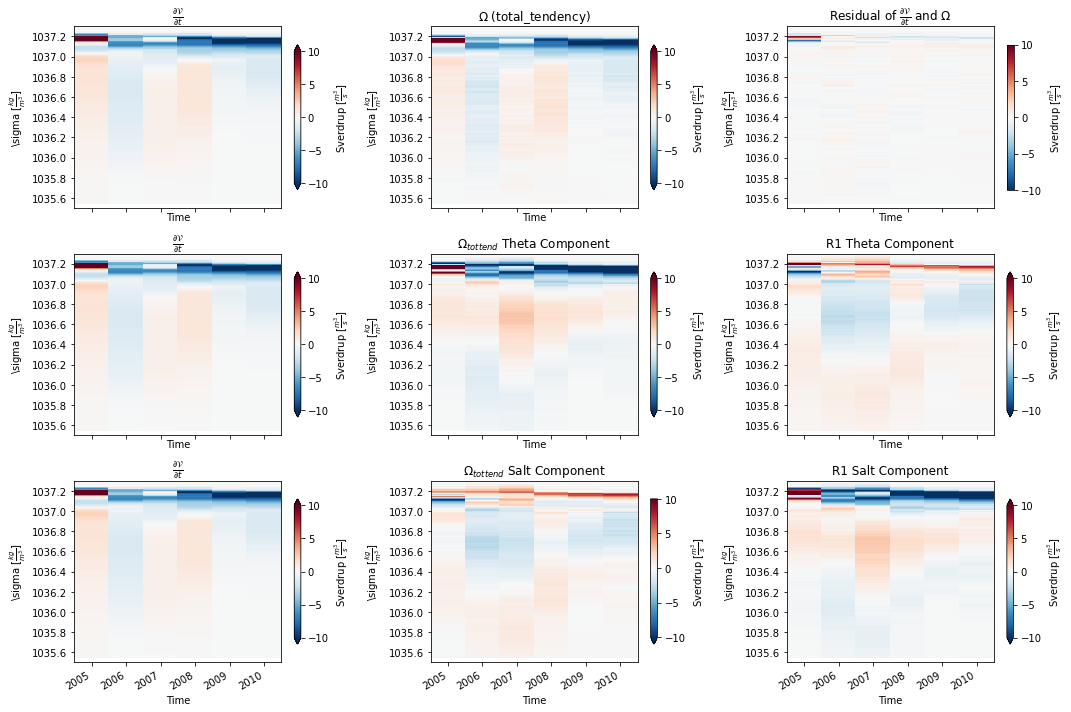

In [32]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)

for i in range(0,3):
    for j in range(0,3): 
        term = plot_terms[i,j]
        title = plot_term_titles[i,j]
        (term/1e6).resample(time='AS').mean(dim='time').plot(x='time', vmax=10, ax=axes[i,j],
                                            cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
        axes[i,j].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
        axes[i,j].set_xlabel('Time')
        axes[i,j].set_title(title)
        axes[i,j].set_ylim(1035.5, 1037.3)
plt.tight_layout();

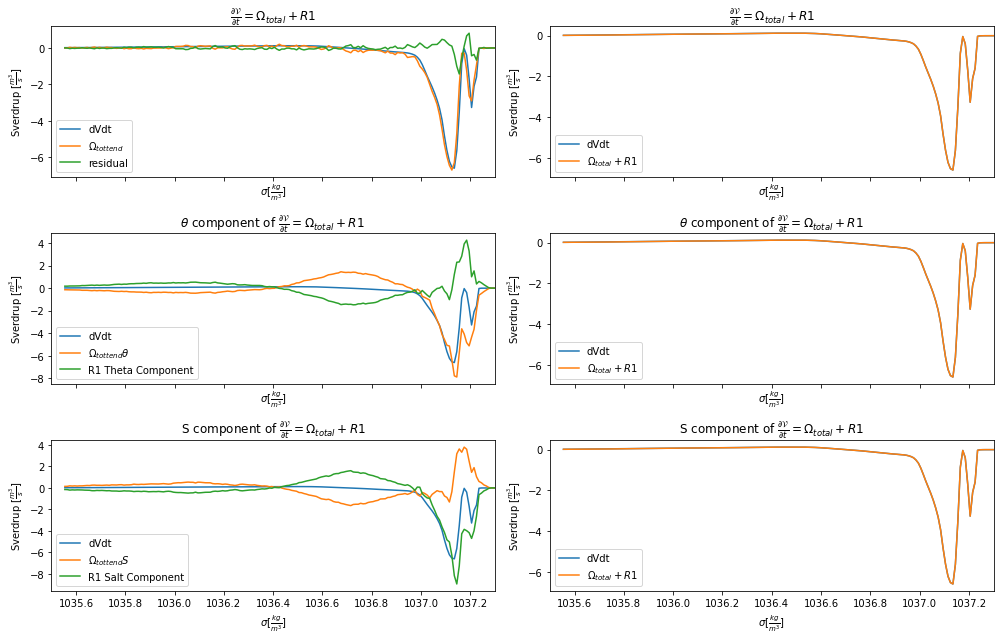

In [33]:
fig, axes = plt.subplots(3, 2, figsize=(14, 9), sharex=True)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[0,0])
(omega_total/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend}$', ax=axes[0,0])
(R1/1e6).mean(dim='time').plot(label='residual', ax=axes[0,0])
axes[0,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[0,0].legend()
axes[0,0].set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
axes[0,0].set_xlim(1035.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[0,1])
((omega_total + R1)/1e6).mean(dim='time').plot(label=r'$\Omega_{total} + R1$', ax=axes[0,1])
axes[0,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[0,1].legend()
axes[0,1].set_title(r'$\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
axes[0,1].set_xlim(1035.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[1,0])
(omega_total_th/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend} \theta$', ax=axes[1,0])
(R1_th/1e6).mean(dim='time').plot(label='R1 Theta Component', ax=axes[1,0])
axes[1,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,0].legend()
axes[1,0].set_title(r'$\theta$ component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$ ')
axes[1,0].set_xlim(1035.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[1,1])
((omega_total_th + R1_th)/1e6).mean(dim='time').plot(label=r'$\Omega_{total} + R1$', ax=axes[1,1])
axes[1,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,1].legend()
axes[1,1].set_title(r'$\theta$ component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
axes[1,1].set_xlim(1035.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[2,0])
(omega_total_slt/1e6).mean(dim='time').plot(label=r'$\Omega_{tottend} S$', ax=axes[2,0])
(R1_slt/1e6).mean(dim='time').plot(label='R1 Salt Component', ax=axes[2,0])
axes[2,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,0].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[2,0].legend()
axes[2,0].set_title(r'S component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
axes[2,0].set_xlim(1035.5, 1037.3)

(dVdt/1e6).mean(dim='time').plot(label='dVdt', ax=axes[2,1])
((omega_total_slt + R1_slt)/1e6).mean(dim='time').plot(label=r'$\Omega_{total} + R1$', ax=axes[2,1])
axes[2,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,1].set_xlabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[2,1].legend()
axes[2,1].set_title(r'S component of $\frac{\partial \mathcal{V}}{\partial t} = \Omega_{total} + R1$')
axes[2,1].set_xlim(1035.5, 1037.3)

plt.tight_layout();

## <span style='color:Green'> \begin{equation*} \Omega_{transformation-rate} \end{equation*}

In [32]:
def histogram_func(variable):
    """Generalized xhistogram's histogram function 
    for adv and diff flux terms"""
    hist = histogram(sigma2.rename('sigma2'), bins=[sigma_bins],
                     weights=variable.fillna(0.), dim=['XC', 'YC', 'Z'])
    return hist / (-delta_sigma)

In [33]:
all_tendencies_th = list(ds_sig_theta)
all_tendencies_slt = list(ds_sig_salt)

In [34]:
all_dsets_th = xr.merge([histogram_func(ds_sig_theta[var]).rename('OMEGA_' + var)
                      for var in all_tendencies_th])
all_dsets_slt = xr.merge([histogram_func(ds_sig_salt[var]).rename('OMEGA_' + var)
                      for var in all_tendencies_slt])

In [35]:
all_dsets = xr.merge([all_dsets_th, all_dsets_slt])

In [36]:
all_dsets_slt

<xarray.Dataset>
Dimensions:                         (sigma2_bin: 199, time: 438)
Coordinates:
  * time                            (time) datetime64[ns] 2005-01-06 ... 2010...
  * sigma2_bin                      (sigma2_bin) float64 1.036e+03 ... 1.038e+03
Data variables:
    OMEGA_conv_horiz_adv_flux_SLT   (time, sigma2_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_conv_horiz_diff_flux_SLT  (time, sigma2_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_conv_vert_adv_flux_SLT    (time, sigma2_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_conv_vert_diff_flux_SLT   (time, sigma2_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_lin_fs_correction_SLT     (time, sigma2_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_surface_flux_conv_SLT     (time, sigma2_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>
    OMEGA_total_tendency_SLT_truth  (time, sigma2_bin) float64 dask.array<chunksize=(1, 199), meta=np.ndarray>

In [39]:
omega_trans_rate_th = - (all_dsets_th.OMEGA_conv_horiz_diff_flux_TH + 
                         all_dsets_th.OMEGA_conv_vert_diff_flux_TH +
                         all_dsets_th.OMEGA_lin_fs_correction_TH +
                         all_dsets_th.OMEGA_sw_flux_conv_TH + 
                         all_dsets_th.OMEGA_surface_flux_conv_TH)
omega_trans_rate_th.load()

omega_trans_rate_slt = - (all_dsets_slt.OMEGA_conv_horiz_diff_flux_SLT + 
                          all_dsets_slt.OMEGA_conv_vert_diff_flux_SLT +
                          all_dsets_slt.OMEGA_lin_fs_correction_SLT +
                          all_dsets_slt.OMEGA_surface_flux_conv_SLT)
omega_trans_rate_slt.load()

omega_trans_rate = omega_trans_rate_th + omega_trans_rate_slt
omega_trans_rate.load()

<xarray.DataArray (time: 438, sigma2_bin: 199)>
array([[ 7.23949124e+07,  8.53214624e+07,  1.02416465e+08, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-6.83153488e+06, -7.78911417e+06, -7.72048191e+06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.44763527e+06, -1.58867179e+06, -3.02207758e+06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-8.86186399e+04, -1.96508974e+05, -2.36625525e+05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-6.35304141e+04,  6.91290274e+03,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.97406870e+04, -9.15638046e+04,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.036e+03 1.036e+03 ... 1.038e+03 1.038e+03

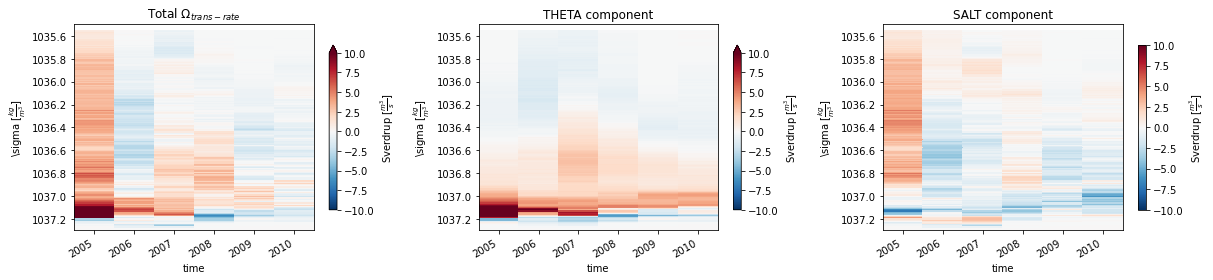

In [40]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

(omega_trans_rate.resample(time='AS').mean()/1e6).plot(x='time', ax=ax0, vmax=10,
                                                       cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax0.set_ylim(1037.3, 1035.5)
ax0.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax0.set_title(r'Total $\Omega_{trans-rate}$')

(omega_trans_rate_th.resample(time='AS').mean()/1e6).plot(x='time', ax=ax1, vmax=10,
                                                          cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax1.set_ylim(1037.3, 1035.5)
ax1.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax1.set_title('THETA component')

(omega_trans_rate_slt.resample(time='AS').mean()/1e6).plot(x='time', ax=ax2, vmax=10,
                                                           cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax2.set_ylim(1037.3, 1035.5)
ax2.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax2.set_title('SALT component')

plt.tight_layout();

## <font color='Green'> \begin{equation*} \Psi_{adv} = \Psi_{vel} + R2 \end{equation*} (Numerical Mixing) </font>

## $\Psi_{adv}$

In [37]:
psi_adv_th = -(all_dsets_th.OMEGA_conv_horiz_adv_flux_TH + all_dsets_th.OMEGA_conv_vert_adv_flux_TH)
psi_adv_th.load()
psi_adv_slt = -(all_dsets_slt.OMEGA_conv_horiz_adv_flux_SLT + all_dsets_slt.OMEGA_conv_vert_adv_flux_SLT)
psi_adv_slt.load()
psi_adv = psi_adv_th + psi_adv_slt
psi_adv.load()

<xarray.DataArray (time: 438, sigma2_bin: 199)>
array([[-7.95678907e+07, -9.29768752e+07, -1.10501630e+08, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 9.33612709e+06,  9.45650687e+06,  1.16270348e+07, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.74393164e+06,  1.99185313e+06,  3.60386733e+06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 4.86384476e+04,  8.90328485e+04,  2.02313290e+05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.32737207e+05,  7.46144463e+04,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.50893155e+05, -1.01877477e+05,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.036e+03 1.036e+03 ... 1.038e+03 1.038e+03

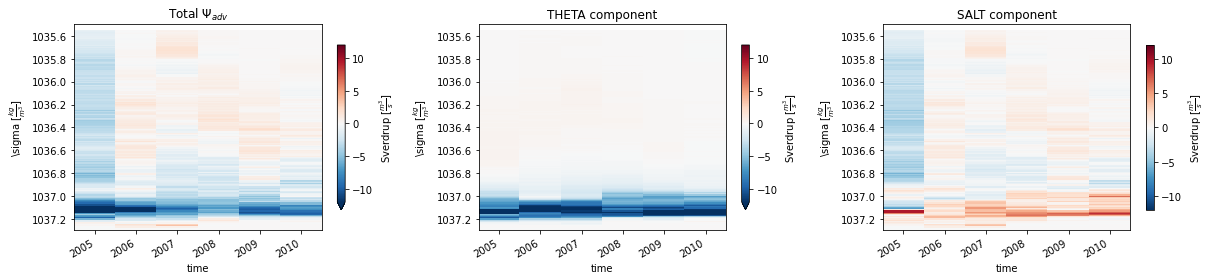

In [38]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(17,4))

(psi_adv.resample(time='AS').mean()/1e6).plot(x='time', ax=ax0, vmax=12,
                                                       cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax0.set_ylim(1037.3, 1035.5)
ax0.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax0.set_title(r'Total $\Psi_{adv}$')

(psi_adv_th.resample(time='AS').mean()/1e6).plot(x='time', ax=ax1, vmax=12,
                                                          cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax1.set_ylim(1037.3, 1035.5)
ax1.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax1.set_title('THETA component')

(psi_adv_slt.resample(time='AS').mean()/1e6).plot(x='time', ax=ax2, vmax=12,
                                                           cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
ax2.set_ylim(1037.3, 1035.5)
ax2.set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
ax2.set_title('SALT component')

plt.tight_layout();

## $\Psi_{vel}$

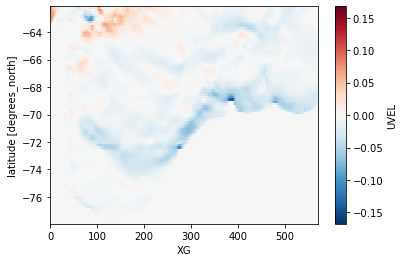

In [106]:
ds.UVEL.mean(dim=['time', 'Z']).drop('XG').plot()

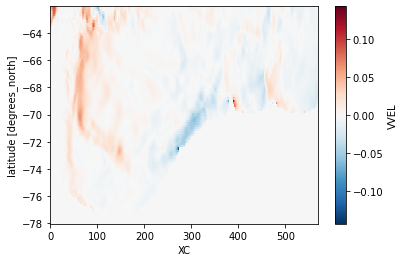

In [107]:
ds.VVEL.mean(dim=['time', 'Z']).drop('XC').plot()

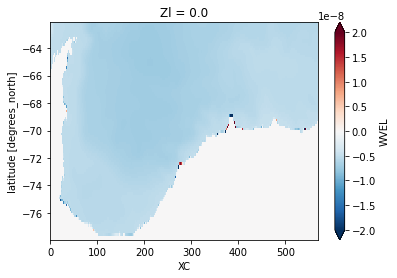

In [108]:
ds.WVEL.mean('time')[0].drop('XC').plot(vmax=0.2e-7)

In [113]:
mask

<xarray.DataArray 'surface_flux_conv_SLT' (time: 438, Z: 42, YC: 95, XC: 570)>
dask.array<where, shape=(438, 42, 95, 570), dtype=float32, chunksize=(1, 42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [122]:
ds.WSLTMASS

<xarray.DataArray 'WSLTMASS' (time: 438, Zl: 42, YC: 95, XC: 570)>
dask.array<xarray-WSLTMASS, shape=(438, 42, 95, 570), dtype=float32, chunksize=(1, 42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * Zl       (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4.95e+03 -5.2e+03 -5.45e+03
Attributes:
    coordinates:    iter Depth rA
    long_name:      Vertical Mass-Weight Transp of Salinity
    standard_name:  WSLTMASS
    units:          psu.m/s

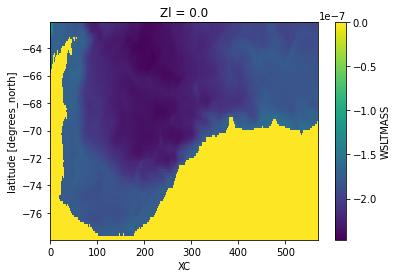

In [115]:
ds.WSLTMASS.mean('time')[0].drop('XC').plot()

In [123]:
ds.WTHMASS

<xarray.DataArray 'WTHMASS' (time: 438, Zl: 42, YC: 95, XC: 570)>
dask.array<xarray-WTHMASS, shape=(438, 42, 95, 570), dtype=float32, chunksize=(1, 42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * Zl       (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4.95e+03 -5.2e+03 -5.45e+03
Attributes:
    coordinates:    iter Depth rA
    long_name:      Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    standard_name:  WTHMASS
    units:          degC.m/s

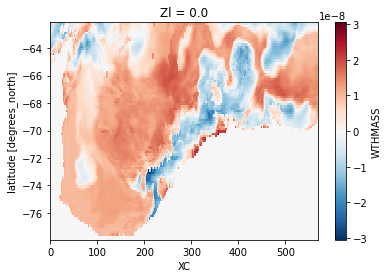

In [116]:
ds.WTHMASS.mean('time')[0].drop('XC').plot()

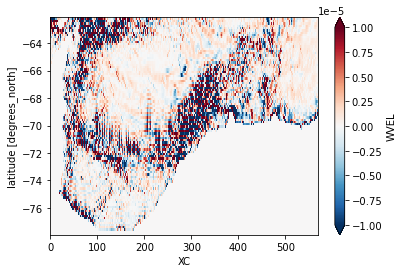

In [102]:
ds.WVEL.mean(dim=['time', 'Zl']).drop('XC').plot(vmax=1e-5)

In [93]:
ds.UVEL

<xarray.DataArray 'UVEL' (time: 438, Z: 42, YC: 95, XG: 571)>
dask.array<xarray-UVEL, shape=(438, 42, 95, 571), dtype=float32, chunksize=(1, 42, 95, 571), chunktype=numpy.ndarray>
Coordinates:
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * XG       (XG) float32 295.0 295.2 295.3 295.5 ... 29.5 29.67 29.83 30.0
Attributes:
    long_name:      Zonal Component of Velocity (m/s)
    mate:           VVEL
    standard_name:  UVEL
    units:          m/s

In [59]:
empmr

<xarray.Dataset>
Dimensions:  (XC: 570, YC: 95, time: 438)
Coordinates:
  * XC       (XC) float32 51.75 51.92 52.08 52.25 ... 146.1 146.2 146.4 146.6
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Data variables:
    SIempmr  (time, YC, XC) float32 dask.array<chunksize=(1, 95, 570), meta=np.ndarray>

In [115]:
#this is the "dA" part of the equation
u_transport_right = (ds.UVEL * coords.dyG * coords.drF).isel(XG=-1) #m^3/s #(-) values -> westward, (+) values -> east
u_transport_left = (ds.UVEL * coords.dyG * coords.drF).isel(XG=0)

v_transport = (ds.VVEL * coords.dxG * coords.drF).isel(YG=-1) #m^3/s #(-) values -> south, (+) values -> north
w_transport = ds.WVEL.isel(Zl=0) * coords.rA

empmr_transport = (empmr.SIempmr/1034) * coords.rA #1034=rho

In [113]:
ds.WVEL

<xarray.DataArray 'WVEL' (time: 438, Zl: 42, YC: 95, XC: 570)>
dask.array<xarray-WVEL, shape=(438, 42, 95, 570), dtype=float32, chunksize=(1, 42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * Zl       (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4.95e+03 -5.2e+03 -5.45e+03
Attributes:
    long_name:      Vertical Component of Velocity (r_units/s)
    standard_name:  WVEL
    units:          m/s

In [114]:
empmr.SIempmr

<xarray.DataArray 'SIempmr' (time: 438, YC: 95, XC: 570)>
dask.array<xarray-SIempmr, shape=(438, 95, 570), dtype=float32, chunksize=(1, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    coordinates:    iter Depth rA
    long_name:      Ocean surface freshwater flux, > 0 increases salt
    standard_name:  SIempmr
    units:          kg/m^2/s

In [87]:
empmr.SIempmr

<xarray.DataArray 'SIempmr' (time: 438, YC: 95, XC: 570)>
dask.array<xarray-SIempmr, shape=(438, 95, 570), dtype=float32, chunksize=(1, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    coordinates:    iter Depth rA
    long_name:      Ocean surface freshwater flux, > 0 increases salt
    standard_name:  SIempmr
    units:          kg/m^2/s

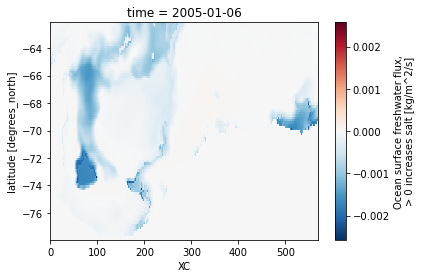

In [89]:
empmr.SIempmr[0].drop('XC').plot()

In [73]:
coords.rA

<xarray.DataArray 'rA' (YC: 95, XC: 570)>
dask.array<xarray-rA, shape=(95, 570), dtype=float32, chunksize=(95, 570), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
Attributes:
    coordinate:     YC XC
    long_name:      cell area
    standard_name:  cell_area
    units:          m2

In [117]:
w_transport = (ds.WTHMASS + ds.WSLTMASS).isel(Zl=0) * coords.rA #m^3/s #(-) values are massflux into the ocean, (+) values are massflux out of the ocean

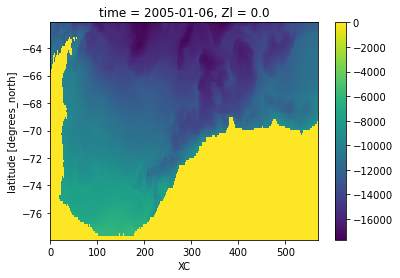

In [121]:
w_transport[0].drop('XC').plot()

In [129]:
u_transport_mean_value = (u_transport_right.sum(dim=['YC', 'Z']) -
                          u_transport_left.sum(dim=['YC', 'Z'])).mean(dim='time')/1e6
u_transport_mean_value.load()

<xarray.DataArray ()>
array(-45.03806, dtype=float32)

In [130]:
v_transport_mean_value = (v_transport).mean(dim='time').sum()/1e6
v_transport_mean_value.load()

<xarray.DataArray ()>
array(46.015747, dtype=float32)
Coordinates:
    YG       float32 -62.12

In [131]:
w_transport_mean_value = w_transport.mean(dim='time').sum()/1e6
w_transport_mean_value.load()

<xarray.DataArray ()>
array(-0.02791281, dtype=float32)
Coordinates:
    Zl       float32 0.0

In [132]:
empmr_transport_mean_value = empmr_transport.mean(dim='time').sum()/1e6
empmr_transport_mean_value.load()

<xarray.DataArray ()>
array(-0.02126679)

In [134]:
u_transport_20 = (u_transport_right[20].sum(dim=['YC', 'Z']) -
                          u_transport_left[20].sum(dim=['YC', 'Z']))/1e6
u_transport_20.load()

<xarray.DataArray ()>
array(-50.686184, dtype=float32)
Coordinates:
    time     datetime64[ns] 2005-04-16

In [136]:
v_transport_20 = v_transport[0].sum()/1e6
v_transport_20.load()

<xarray.DataArray ()>
array(34.030563, dtype=float32)
Coordinates:
    time     datetime64[ns] 2005-01-06
    YG       float32 -62.12

In [137]:
w_transport_20 = w_transport[0].sum()/1e6
w_transport_20.load()

<xarray.DataArray ()>
array(-13.179214, dtype=float32)
Coordinates:
    time     datetime64[ns] 2005-01-06
    Zl       float32 0.0

In [138]:
empmr_transport_20 = empmr_transport[0].sum()/1e6
empmr_transport_20.load()

<xarray.DataArray ()>
array(-1.0041945)
Coordinates:
    time     datetime64[ns] 2005-01-06

In [139]:
residual_20 = u_transport_20 + v_transport_20 + w_transport_20 + empmr_transport_20
residual_20

<xarray.DataArray ()>
array(-30.83902955)
Coordinates:
    YG       float32 -62.12
    time     datetime64[ns] 2005-01-06
    Zl       float32 0.0

In [133]:
residual = u_transport_mean_value + v_transport_mean_value + w_transport_mean_value + empmr_transport_mean_value
residual

<xarray.DataArray ()>
array(0.92850825)
Coordinates:
    YG       float32 -62.12
    Zl       float32 0.0

In [61]:
# hack sigma to be on same grid pt as velocity components
sigma_at_u_right = sigma2.isel(XC=-1)
sigma_at_u_left = sigma2.isel(XC=0)
sigma_at_v = sigma2.isel(YC=-1)
sigma_at_w = sigma2.isel(Z=0)

In [62]:
sigma_at_u_right.load()
sigma_at_u_left.load()
sigma_at_v.load()
sigma_at_w.load()

distributed.client - WARNING - Couldn't gather 16 keys, rescheduling {"('getitem-55783fd88cb122b346092ea588352c7e', 0, 0, 0)": (), "('getitem-55783fd88cb122b346092ea588352c7e', 82, 0, 0)": (), "('getitem-55783fd88cb122b346092ea588352c7e', 87, 0, 0)": (), "('getitem-55783fd88cb122b346092ea588352c7e', 12, 0, 0)": (), "('getitem-55783fd88cb122b346092ea588352c7e', 263, 0, 0)": (), "('getitem-55783fd88cb122b346092ea588352c7e', 346, 0, 0)": (), "('getitem-55783fd88cb122b346092ea588352c7e', 135, 0, 0)": (), "('getitem-55783fd88cb122b346092ea588352c7e', 296, 0, 0)": (), "('getitem-55783fd88cb122b346092ea588352c7e', 47, 0, 0)": (), "('getitem-55783fd88cb122b346092ea588352c7e', 128, 0, 0)": (), "('getitem-55783fd88cb122b346092ea588352c7e', 85, 0, 0)": (), "('getitem-55783fd88cb122b346092ea588352c7e', 54, 0, 0)": (), "('getitem-55783fd88cb122b346092ea588352c7e', 327, 0, 0)": (), "('getitem-55783fd88cb122b346092ea588352c7e', 37, 0, 0)": (), "('getitem-55783fd88cb122b346092ea588352c7e', 297, 0, 0)"

<xarray.DataArray (time: 438, YC: 95, XC: 570)>
array([[[1009.78877989, 1009.78877989, 1009.78877989, ...,
         1009.78877989, 1009.78877989, 1009.78877989],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1009.78877989, 1009.78877989, 1009.78877989],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1009.78877989, 1009.78877989, 1009.78877989],
        ...,
        [1036.05784705, 1036.0563879 , 1036.0531513 , ...,
         1036.13668678, 1036.13996092, 1036.14223767],
        [1036.03774545, 1036.0364464 , 1036.03370729, ...,
         1036.10798252, 1036.1086661 , 1036.10883218],
        [1036.01037389, 1036.011094  , 1036.01048784, ...,
         1036.09182463, 1036.09097207, 1036.09016002]],

       [[1009.78877989, 1009.78877989, 1009.78877989, ...,
         1009.78877989, 1009.78877989, 1009.78877989],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1009.78877989, 1009.78877989, 1009.78877989],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1009.78877989, 1009.78877989, 1009.78877989],
...
        [1036.13437935, 1036.13058819, 1036.1301778 , ...,
         1036.71621701, 1036.71209368, 1036.70807764],
        [1036.12682076, 1036.12839169, 1036.1313443 , ...,
         1036.69343845, 1036.69005532, 1036.68750517],
        [1036.1315441 , 1036.1351828 , 1036.138223  , ...,
         1036.68257406, 1036.67954211, 1036.67756196]],

       [[1009.78877989, 1009.78877989, 1009.78877989, ...,
         1009.78877989, 1009.78877989, 1009.78877989],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1009.78877989, 1009.78877989, 1009.78877989],
        [1009.78877989, 1009.78877989, 1009.78877989, ...,
         1009.78877989, 1009.78877989, 1009.78877989],
        ...,
        [1036.06954294, 1036.06568943, 1036.06707685, ...,
         1036.58093249, 1036.57889777, 1036.57733219],
        [1036.06172363, 1036.06317606, 1036.0666752 , ...,
         1036.55869698, 1036.55632901, 1036.55449939],
        [1036.06106256, 1036.06659287, 1036.07168576, ...,
         1036.54658356, 1036.54323383, 1036.54054124]]])
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
    Z        float32 -5.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [66]:
u_transport_right.load()

<xarray.DataArray (time: 438, Z: 42, YC: 95)>
array([[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -3.6375186e+02, -6.5288580e+02,  4.2363424e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -2.6480872e+02, -1.6018822e+02,  1.7776927e+02],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -4.6306448e+02, -8.0652298e+01,  8.0926773e+01],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          2.0269332e+03,  1.0316454e+03,  3.0294915e+03],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -2.2267429e+03, -1.8631833e+03, -1.7145078e+03],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -1.0172824e+02, -3.1798825e+02,  3.9665125e+02],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -3.4110565e+02, -2.1665181e+02,  3.9331714e+02],
...
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -1.7317736e+04, -4.1978520e+04, -5.2406176e+04],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -5.3503949e+02,  1.5963330e+03,  2.4100388e+03],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -5.4858018e+03, -3.0620391e+03, -2.2692759e+03],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         -6.7682036e+03, -3.5540405e+03, -2.5086152e+03],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          8.9589141e+03, -1.8249016e+04, -2.5572678e+04],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]], dtype=float32)
Coordinates:
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    XG       float32 30.0

In [67]:
u_transport_left.load()

<xarray.DataArray (time: 438, Z: 42, YC: 95)>
array([[[     0.     ,      0.     ,      0.     , ...,   7469.4766 ,
          26079.223  ,  37609.203  ],
        [     0.     ,      0.     ,      0.     , ...,   2254.7817 ,
          22940.617  ,  35989.8    ],
        [     0.     ,      0.     ,      0.     , ...,   1080.9448 ,
          23901.594  ,  38285.84   ],
        ...,
        [     0.     ,      0.     ,      0.     , ...,      0.     ,
              0.     ,      0.     ],
        [     0.     ,      0.     ,      0.     , ...,      0.     ,
              0.     ,      0.     ],
        [     0.     ,      0.     ,      0.     , ...,      0.     ,
              0.     ,      0.     ]],

       [[     0.     ,      0.     ,      0.     , ..., -13133.107  ,
           1389.9474 ,  26117.266  ],
        [     0.     ,      0.     ,      0.     , ..., -13725.733  ,
           2354.1047 ,  29478.078  ],
        [     0.     ,      0.     ,      0.     , ..., -16345.793  ,
           1120.3207 ,  30882.182  ],
...
        [     0.     ,      0.     ,      0.     , ...,      0.     ,
              0.     ,      0.     ],
        [     0.     ,      0.     ,      0.     , ...,      0.     ,
              0.     ,      0.     ],
        [     0.     ,      0.     ,      0.     , ...,      0.     ,
              0.     ,      0.     ]],

       [[     0.     ,      0.     ,      0.     , ...,  27437.627  ,
          15903.638  ,   6064.967  ],
        [     0.     ,      0.     ,      0.     , ...,  26734.441  ,
          13491.149  ,   1913.8492 ],
        [     0.     ,      0.     ,      0.     , ...,  25929.238  ,
          12004.949  ,   -806.1666 ],
        ...,
        [     0.     ,      0.     ,      0.     , ...,      0.     ,
              0.     ,      0.     ],
        [     0.     ,      0.     ,      0.     , ...,      0.     ,
              0.     ,      0.     ],
        [     0.     ,      0.     ,      0.     , ...,      0.     ,
              0.     ,      0.     ]]], dtype=float32)
Coordinates:
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    XG       float32 295.0

In [68]:
v_transport.load()

<xarray.DataArray (time: 438, Z: 42, XC: 570)>
array([[[ 10006.59   ,   9114.26   ,   7924.1064 , ...,    316.67834,
            234.7969 ,    131.806  ],
        [ 10893.124  ,   9892.3545 ,   8577.128  , ...,   -598.91223,
           -643.9089 ,   -709.25256],
        [ 10798.21   ,   9733.189  ,   8312.6    , ...,   -523.11084,
           -577.75055,   -653.0387 ],
        ...,
        [     0.     ,      0.     ,      0.     , ...,   5034.493  ,
           5308.956  ,   5496.03   ],
        [     0.     ,      0.     ,      0.     , ...,      0.     ,
              0.     ,      0.     ],
        [     0.     ,      0.     ,      0.     , ...,      0.     ,
              0.     ,      0.     ]],

       [[ 10423.91   ,   7526.055  ,   3854.657  , ...,    956.0308 ,
            913.7638 ,    848.6734 ],
        [ 12577.611  ,   9324.325  ,   5219.632  , ...,   -689.5311 ,
           -741.5303 ,   -815.3844 ],
        [ 13949.471  ,  10418.797  ,   5921.233  , ...,   -720.6549 ,
           -778.31445,   -851.73755],
...
        [     0.     ,      0.     ,      0.     , ..., -10764.193  ,
         -10828.343  , -10260.68   ],
        [     0.     ,      0.     ,      0.     , ...,      0.     ,
              0.     ,      0.     ],
        [     0.     ,      0.     ,      0.     , ...,      0.     ,
              0.     ,      0.     ]],

       [[  2815.8125 ,   2725.256  ,   4550.1426 , ...,  -3643.791  ,
          -3857.3337 ,  -3976.6338 ],
        [  4627.1904 ,   4552.1353 ,   6652.0107 , ...,  -1384.6714 ,
          -1587.5623 ,  -1701.6239 ],
        [  4221.2334 ,   4216.95   ,   6551.086  , ...,  -1585.3152 ,
          -1836.8367 ,  -1977.8396 ],
        ...,
        [     0.     ,      0.     ,      0.     , ...,  -8380.576  ,
          -8474.541  ,  -7939.7617 ],
        [     0.     ,      0.     ,      0.     , ...,      0.     ,
              0.     ,      0.     ],
        [     0.     ,      0.     ,      0.     , ...,      0.     ,
              0.     ,      0.     ]]], dtype=float32)
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -62.12

In [69]:
w_transport.load()

<xarray.DataArray (time: 438, YC: 95, XC: 570)>
array([[[   0.       ,    0.       ,    0.       , ...,    0.       ,
            0.       ,    0.       ],
        [   0.       ,    0.       ,    0.       , ...,    0.       ,
            0.       ,    0.       ],
        [   0.       ,    0.       ,    0.       , ...,    0.       ,
            0.       ,    0.       ],
        ...,
        [-324.3026   , -332.87204  , -339.4576   , ..., -368.9093   ,
         -368.53656  , -368.146    ],
        [-322.6103   , -329.6862   , -334.8172   , ..., -370.68356  ,
         -370.31912  , -369.9333   ],
        [-312.7807   , -319.1278   , -323.55502  , ..., -372.42264  ,
         -372.0782   , -371.71558  ]],

       [[   0.       ,    0.       ,    0.       , ...,    0.       ,
            0.       ,    0.       ],
        [   0.       ,    0.       ,    0.       , ...,    0.       ,
            0.       ,    0.       ],
        [   0.       ,    0.       ,    0.       , ...,    0.       ,
            0.       ,    0.       ],
...
        [ -27.963709 ,  -27.009863 ,  -25.787552 , ..., -154.73778  ,
         -154.0501   , -153.33032  ],
        [ -28.66875  ,  -26.501705 ,  -24.474531 , ..., -156.69313  ,
         -155.9452   , -155.15085  ],
        [ -27.12146  ,  -25.806787 ,  -24.305447 , ..., -158.2697   ,
         -157.47052  , -156.62048  ]],

       [[   0.       ,    0.       ,    0.       , ...,    0.       ,
            0.       ,    0.       ],
        [   0.       ,    0.       ,    0.       , ...,    0.       ,
            0.       ,    0.       ],
        [   0.       ,    0.       ,    0.       , ...,    0.       ,
            0.       ,    0.       ],
        ...,
        [ -47.7762   ,  -46.554653 ,  -44.33106  , ...,   83.40443  ,
           82.89121  ,   82.37763  ],
        [ -44.100166 ,  -41.976646 ,  -39.76883  , ...,   84.259964 ,
           83.77605  ,   83.286095 ],
        [ -38.672424 ,  -36.45853  ,  -34.785526 , ...,   85.24197  ,
           84.76565  ,   84.266914 ]]], dtype=float32)
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    Zl       float32 0.0

In [116]:
empmr_transport.load()

<xarray.DataArray (time: 438, YC: 95, XC: 570)>
array([[[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [ -4.594596  ,  -4.6395025 ,  -4.697456  , ...,  -1.6274066 ,
          -1.5914263 ,  -1.5506383 ],
        [ -4.4818306 ,  -4.504013  ,  -4.5382323 , ...,  -1.7972804 ,
          -1.7495327 ,  -1.6960958 ],
        [ -4.2776985 ,  -4.307747  ,  -4.3415246 , ...,  -1.6220152 ,
          -1.572373  ,  -1.5156721 ]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
...
        [ -4.4127975 ,  -4.3825026 ,  -4.342889  , ..., -29.336315  ,
         -29.502272  , -29.610596  ],
        [ -4.3826604 ,  -4.369113  ,  -4.3314943 , ..., -29.321104  ,
         -29.485167  , -29.756004  ],
        [ -4.4601507 ,  -4.46151   ,  -4.410974  , ..., -29.33093   ,
         -29.669386  , -29.788816  ]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [ -8.7017565 ,  -8.623997  ,  -8.5308075 , ..., -31.518959  ,
         -31.704313  , -31.935905  ],
        [ -8.83899   ,  -8.823467  ,  -8.775066  , ..., -31.546247  ,
         -31.729998  , -31.886353  ],
        [ -8.935556  ,  -8.9853    ,  -8.974677  , ..., -31.969862  ,
         -32.19449   , -32.290863  ]]], dtype=float32)
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [91]:
#this is the delta function part of the equation above
u_binned_right = histogram(sigma_at_u_right.rename('sigma2'), bins=[sigma_bins],
                           weights=u_transport_right, dim=['Z', 'YC'])

In [92]:
u_binned_left = histogram(sigma_at_u_left.rename('sigma2'), bins=[sigma_bins],
                          weights=u_transport_left, dim=['Z', 'YC'])

In [93]:
v_binned = histogram(sigma_at_v.rename('sigma2'), bins=[sigma_bins],
                     weights=v_transport, dim=['Z', 'XC'])

In [94]:
w_binned = histogram(sigma_at_w.rename('sigma2'), bins=[sigma_bins],
                     weights=w_transport, dim=['XC', 'YC'])

In [117]:
empmr_binned = histogram(sigma_at_w.rename('sigma2'), bins=[sigma_bins],
                         weights=empmr_transport, dim=['XC', 'YC'])

# Potential Bug: two u_binned, putting into one big computation - dask getting confused as to which u was which.

In [125]:
#`isel` is letting cumsum act in reverse order (from densenst to lightest)
psi_vel = - (u_binned_right 
             - u_binned_left 
             + v_binned 
             + w_binned
             - empmr_binned).isel(sigma2_bin=slice(None, None, -1)).cumsum(dim='sigma2_bin')
psi_vel.load()

<xarray.DataArray 'histogram_sigma2' (time: 438, sigma2_bin: 199)>
array([[      -0.        ,       -0.        ,       -0.        , ...,
        -1322972.17423976, -1291608.2239346 , -1262701.34260184],
       [      -0.        ,       -0.        ,       -0.        , ...,
        -1033219.71215847, -1043745.87107737, -1049087.97075357],
       [      -0.        ,       -0.        ,       -0.        , ...,
        -1156373.37093284, -1157415.43025723, -1139219.10460833],
       ...,
       [      -0.        ,       -0.        ,       -0.        , ...,
        -1872186.12418655, -1872227.56620315, -1872265.76816753],
       [      -0.        ,       -0.        ,       -0.        , ...,
        -1774171.85129751, -1770788.09787954, -1771591.43684496],
       [      -0.        ,       -0.        ,       -0.        , ...,
        -1338753.62702889, -1338640.75845188, -1338617.23819965]])
Coordinates:
  * time        (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * sigma2_bin  (sigma2_bin) float64 1.038e+03 1.038e+03 ... 1.036e+03 1.036e+03

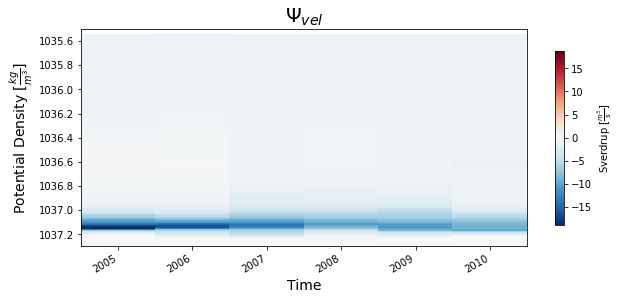

In [126]:
(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', figsize=(10,4), 
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
plt.ylabel(r'Potential Density $[\frac{kg}{m^3}]$', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('$\Psi_{vel}$', fontsize=20)
plt.ylim(1037.3, 1035.5);

(1035.5, 1037.3)

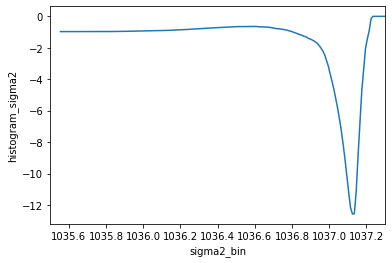

In [127]:
(psi_vel/1e6).mean(dim='time').plot()
plt.xlim(1035.5, 1037.3)

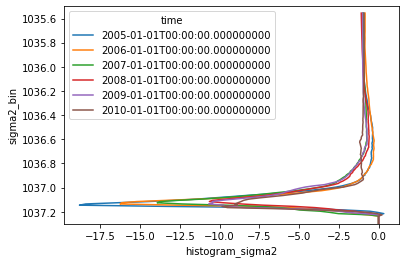

In [128]:
(psi_vel/1e6).resample(time='AS').mean(dim='time').plot.line(y='sigma2_bin', add_legend=True)
plt.ylim(1037.3, 1035.5);

## R2 = $\Psi_{adv} - \Psi_{vel}$ (Numerical Mixing)

In [110]:
R2 = (psi_adv - psi_vel).load()
R2_th = (psi_adv_th - psi_vel).load()
R2_slt = (psi_adv_slt - psi_vel).load()

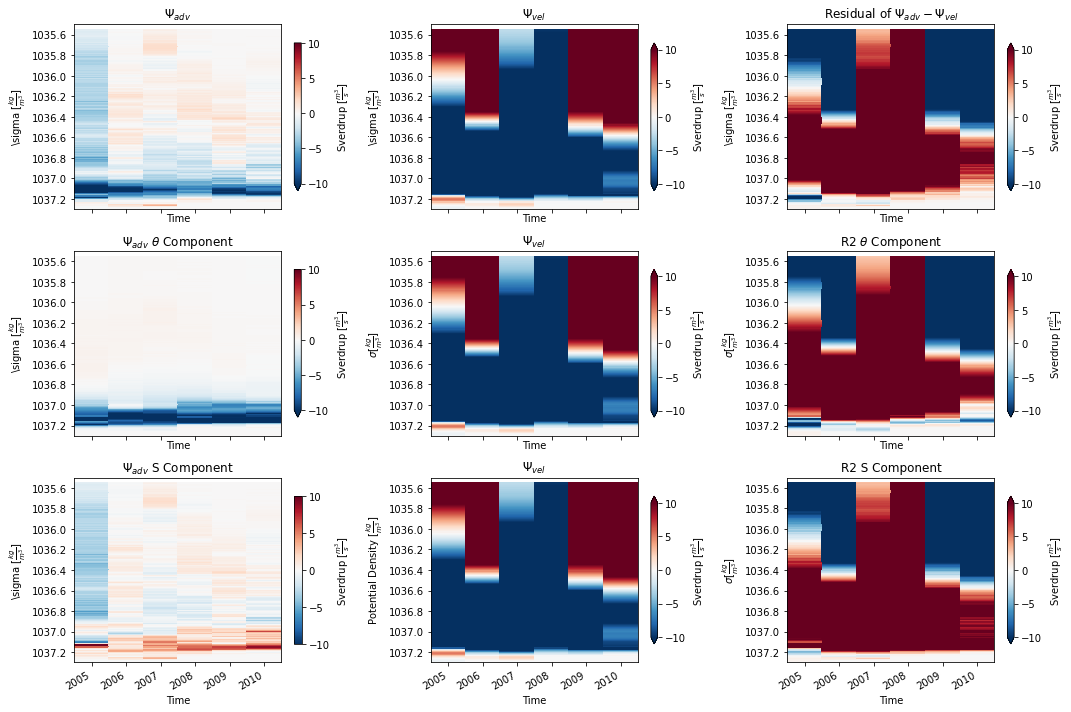

In [111]:
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)

(psi_adv/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,0], vmax=10,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[0,0].set_xlabel('Time')
axes[0,0].set_title(r'$\Psi_{adv}$')
axes[0,0].set_ylim(1037.3, 1035.5)

(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,1], vmax=10, 
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,1].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[0,1].set_xlabel('Time')
axes[0,1].set_title('$\Psi_{vel}$')
axes[0,1].set_ylim(1037.3, 1035.5)

(R2/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[0,2], vmax=10, 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[0,2].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[0,2].set_xlabel('Time')
axes[0,2].set_title(r'Residual of $\Psi_{adv} - \Psi_{vel}$')
axes[0,2].set_ylim(1037.3, 1035.5)

(psi_adv_th/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,0], vmax=10,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[1,0].set_xlabel('Time')
axes[1,0].set_title(r'$\Psi_{adv}$ $\theta$ Component')
axes[1,0].set_ylim(1037.3, 1035.5)

(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,1], vmax=10, 
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,1].set_xlabel('Time')
axes[1,1].set_title('$\Psi_{vel}$')
axes[1,1].set_ylim(1037.3, 1035.5)

(R2_th/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[1,2], vmax=10, 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[1,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[1,2].set_xlabel('Time')
axes[1,2].set_title(r'R2 $\theta$ Component')
axes[1,2].set_ylim(1037.3, 1035.5)

(psi_adv_slt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,0], vmax=10,
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,0].set_ylabel(r'\sigma $[\frac{kg}{m^3}]$')
axes[2,0].set_xlabel('Time')
axes[2,0].set_title(r'$\Psi_{adv}$ S Component')
axes[2,0].set_ylim(1037.3, 1035.5)

(psi_vel/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,1], vmax=10, 
                                                        cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,1].set_ylabel(r'Potential Density $[\frac{kg}{m^3}]$')
axes[2,1].set_xlabel('Time')
axes[2,1].set_title('$\Psi_{vel}$')
axes[2,1].set_ylim(1037.3, 1035.5)

(R2_slt/1e6).resample(time='AS').mean(dim='time').plot(x='time', ax=axes[2,2], vmax=10, 
                                                   cbar_kwargs={'shrink': 0.8, 'label':r'Sverdrup [$\frac{m^3}{s}$]'})
axes[2,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$')
axes[2,2].set_xlabel('Time')
axes[2,2].set_title(r'R2 S Component')
axes[2,2].set_ylim(1037.3, 1035.5)

plt.tight_layout();

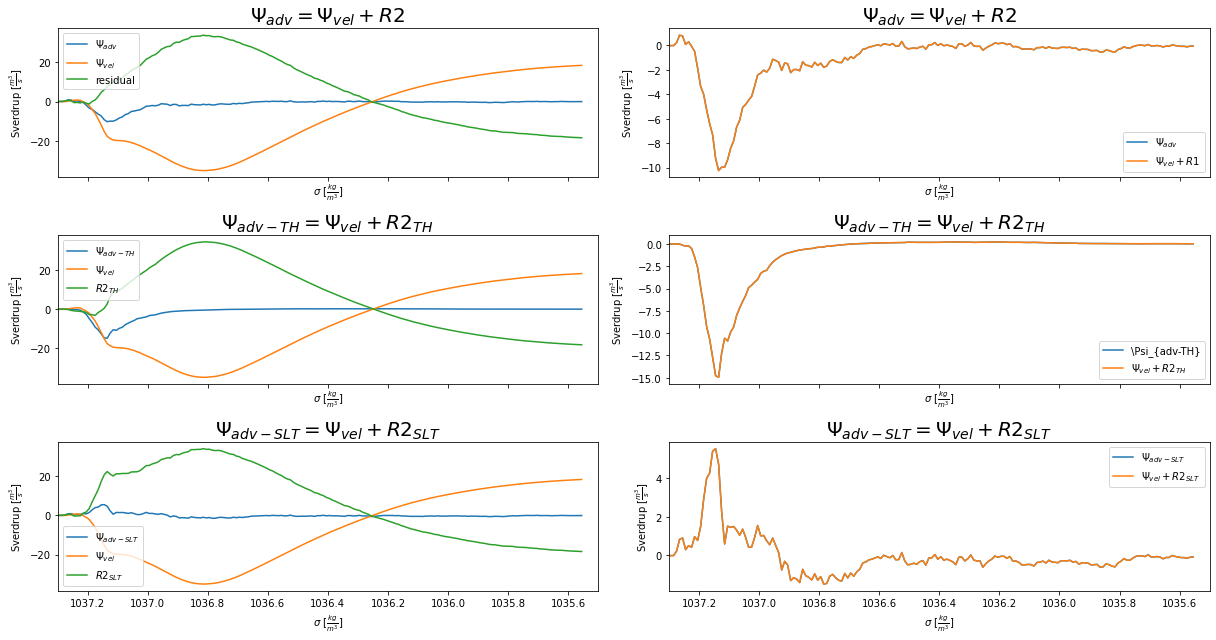

In [112]:
fig, axes = plt.subplots(3, 2, figsize=(17, 9), sharex=True)

(psi_adv/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}$', ax=axes[0,0])
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=axes[0,0])
(R2/1e6).mean(dim='time').plot(label='residual', ax=axes[0,0])
axes[0,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,0].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[0,0].legend()
axes[0,0].set_title(r'$\Psi_{adv} = \Psi_{vel} + R2$', fontsize=20)
axes[0,0].set_xlim(1037.3, 1035.5)

(psi_adv/1e6).mean(dim='time').plot(label=r'$\Psi_{adv}$', ax=axes[0,1])
((psi_vel + R2)/1e6).mean(dim='time').plot(label=r'$\Psi_{vel} + R1$', ax=axes[0,1])
axes[0,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[0,1].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[0,1].legend()
axes[0,1].set_title(r'$\Psi_{adv} = \Psi_{vel} + R2$', fontsize=20)
axes[0,1].set_xlim(1037.3, 1035.5)

(psi_adv_th/1e6).mean(dim='time').plot(label=r'$\Psi_{adv-TH}$', ax=axes[1,0])
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=axes[1,0])
(R2_th/1e6).mean(dim='time').plot(label=r'$R2_{TH}$', ax=axes[1,0])
axes[1,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,0].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[1,0].legend()
axes[1,0].set_title(r'$\Psi_{adv-TH} = \Psi_{vel} + R2_{TH}$ ', fontsize=20)
axes[1,0].set_xlim(1037.3, 1035.5)

(psi_adv_th/1e6).mean(dim='time').plot(label='\Psi_{adv-TH}', ax=axes[1,1])
((psi_vel + R2_th)/1e6).mean(dim='time').plot(label=r'$\Psi_{vel} + R2_{TH}$', ax=axes[1,1])
axes[1,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[1,1].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[1,1].legend()
axes[1,1].set_title(r'$\Psi_{adv-TH} = \Psi_{vel} + R2_{TH}$', fontsize=20)
axes[1,1].set_xlim(1037.3, 1035.5)

(psi_adv_slt/1e6).mean(dim='time').plot(label=r'$\Psi_{adv-SLT}$', ax=axes[2,0])
(psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi_{vel}$', ax=axes[2,0])
(R2_slt/1e6).mean(dim='time').plot(label=r'$R2_{SLT}$', ax=axes[2,0])
axes[2,0].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,0].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[2,0].legend()
axes[2,0].set_title(r'$\Psi_{adv-SLT} = \Psi_{vel} + R2_{SLT}$', fontsize=20)
axes[2,0].set_xlim(1037.3, 1035.5)

(psi_adv_slt/1e6).mean(dim='time').plot(label=r'$\Psi_{adv-SLT}$', ax=axes[2,1])
((psi_vel + R2_slt)/1e6).mean(dim='time').plot(label=r'$\Psi_{vel} + R2_{SLT}$', ax=axes[2,1])
axes[2,1].set_ylabel(r'Sverdrup [$\frac{m^3}{s}$]')
axes[2,1].set_xlabel(r'$\sigma\ [\frac{kg}{m^3}]$')
axes[2,1].legend()
axes[2,1].set_title(r'$\Psi_{adv-SLT} = \Psi_{vel} + R2_{SLT}$', fontsize=20)
axes[2,1].set_xlim(1037.3, 1035.5)

plt.tight_layout();

# <font color='Green'>\begin{equation*} \Omega_{tottend-truth} = \Psi_{adv} + \Omega_{trans-rate} + R3 \end{equation*} </font>